# Test constants

In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu = [0]
num_workers = 10
pin_memory = True
batch_size = 95

nb_epochs = 10
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations.nc', combine='by_coords')
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [2]:
from modules.data import WeatherBenchDatasetIterative

'''def create_iterative_predictions_healpix(model, device, dg):
    train_std =  dg.dataset.std.values[:2]
    train_mean = dg.dataset.mean.values[:2]
    
    delta_t = dg.dataset.lead_time
    max_lead_time = dg.dataset.max_lead_time
    initial_lead_time = delta_t
    nodes = dg.dataset.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.dataset.n_samples
    in_feat = dg.dataset.in_features
    out_feat = dg.dataset.out_features
    
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.dataset.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.dataset.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in ['z', 't']}
    
    # Radiation
    constants = np.array(dg.dataset.data.isel(level=slice(out_feat, None)).values)
    
    dataloader = dg
    predictions = []
    model.eval()
    for lead in lead_times:
        outputs = []
        state = []
        states = np.empty((n_samples, nodes, in_feat))
        
        time1 = time.time()

        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)

            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            state.append(output.detach().cpu().clone().numpy())
            
        preds = np.concatenate(outputs)
        states[:, :, :out_feat] = np.concatenate(state)
        states[:, :, out_feat:] = constants[lead:n_samples+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds'''


def create_iterative_predictions_healpix(model, device, dg):
    train_std =  dg.dataset.std.values[:2]
    train_mean = dg.dataset.mean.values[:2]
    
    delta_t = dg.dataset.lead_time
    max_lead_time = dg.dataset.max_lead_time
    initial_lead_time = delta_t
    nodes = dg.dataset.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.dataset.n_samples
    in_feat = dg.dataset.in_features
    out_feat = dg.dataset.out_features
    
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.dataset.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.dataset.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in ['z', 't']}
    
    # Radiation
    constants = np.array(dg.dataset.data.isel(level=slice(out_feat, None)).values)
    
    dataloader = dg
    predictions = []
    model.eval()
    for lead in lead_times:
        outputs = []
        state = []
        states = np.empty((n_samples, nodes, in_feat))
        
        time1 = time.time()

        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)

            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            state.append(output.detach().cpu().clone().numpy())
            
        preds = np.concatenate(outputs)
        states[:, :, :out_feat] = np.concatenate(state)
        states[:, :, out_feat:] = constants[lead:n_samples+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds

In [3]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords').rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords').rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords')

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
constants = constants.assign(cos_lon=lambda x: np.cos(np.deg2rad(x.lon)))
constants = constants.assign(sin_lon=lambda x: np.sin(np.deg2rad(x.lon)))

temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

predictors_mean = xr.open_dataarray(datadir + 'predictors_mean.nc')
predictors_std = xr.open_dataarray(datadir + 'predictors_std.nc')
lon_mean = xr.open_dataarray(input_dir + 'constants/lon_mean.nc')
lon_std = xr.open_dataarray(input_dir + 'constants/lon_std.nc')
const_mean = xr.open_dataarray(input_dir + 'constants/const_mean.nc')
const_std = xr.open_dataarray(input_dir + 'constants/const_std.nc')

train_mean = xr.concat((predictors_mean, const_mean, lon_mean), dim='level')

train_std = xr.concat((predictors_std, const_std, lon_std), dim='level')

## 1. No constants

Loading data into RAM
Loading data into RAM
Epoch:   1/  7  - loss: 0.017  - val_loss: 0.01599  - time: 1766.364217
Epoch:   2/  7  - loss: 0.009  - val_loss: 0.00916  - time: 1763.800448
Epoch:   3/  7  - loss: 0.008  - val_loss: 0.00905  - time: 1745.238522
Epoch:   4/  7  - loss: 0.007  - val_loss: 0.00832  - time: 1744.508564
Epoch:   5/  7  - loss: 0.007  - val_loss: 0.00769  - time: 1742.309319
Epoch:   6/  7  - loss: 0.006  - val_loss: 0.00928  - time: 1744.383401
Epoch:   7/  7  - loss: 0.006  - val_loss: 0.00874  - time: 1745.863975


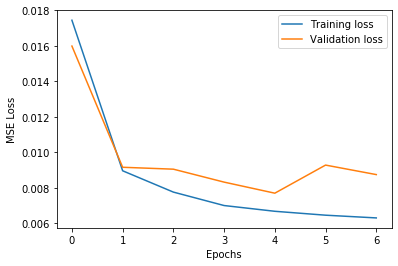

Loading data into RAM
Z500 - 0: 100.30746252911932
T850 - 0: 0.7828726860026753


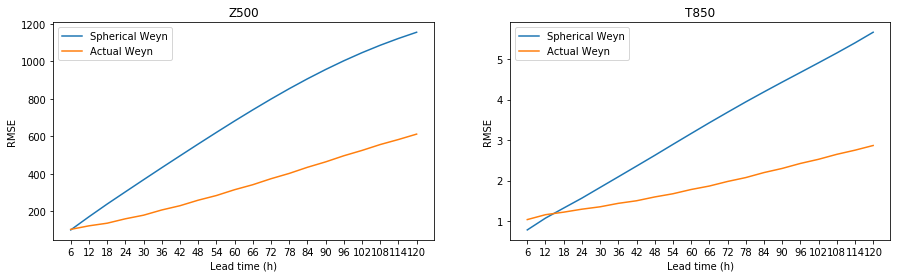

In [4]:
description = "no_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1]
in_features = len(feature_idx)
ds = xr.merge([z500, t850], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=7, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

## 2. All constants

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.025  - val_loss: 0.01099  - time: 2009.741584
Epoch:   2/ 20  - loss: 0.009  - val_loss: 0.01500  - time: 2009.217937
Epoch:   3/ 20  - loss: 0.008  - val_loss: 0.01016  - time: 2012.677809
Epoch:   4/ 20  - loss: 0.007  - val_loss: 0.00734  - time: 2007.970325
Epoch:   5/ 20  - loss: 0.007  - val_loss: 0.00914  - time: 2007.160981
Epoch:   6/ 20  - loss: 0.006  - val_loss: 0.00813  - time: 2008.245269
Epoch:   7/ 20  - loss: 0.006  - val_loss: 0.00657  - time: 1999.720888
Epoch:   8/ 20  - loss: 0.006  - val_loss: 0.00848  - time: 2001.098038
Epoch:   9/ 20  - loss: 0.006  - val_loss: 0.00687  - time: 1997.552423
Epoch:  10/ 20  - loss: 0.006  - val_loss: 0.00688  - time: 1994.658449
Epoch:  11/ 20  - loss: 0.006  - val_loss: 0.00689  - time: 1998.784432
Epoch:  12/ 20  - loss: 0.006  - val_loss: 0.00749  - time: 1994.401030
Epoch:  13/ 20  - loss: 0.006  - val_loss: 0.00625  - time: 1982.177672
Epoch:  14/ 20  - lo

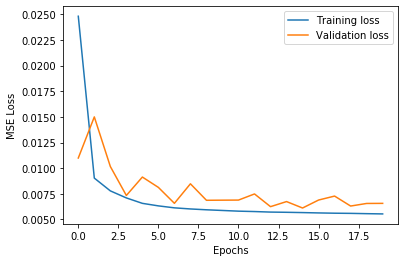

Loading data into RAM
Z500 - 0: 79.83651788630844
T850 - 0: 0.7341381880987584


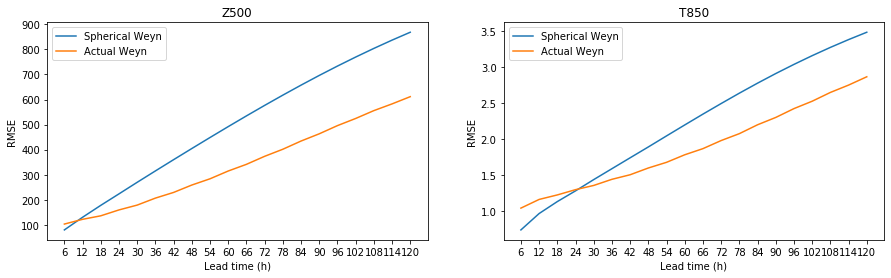

In [4]:
description = "all_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
in_features = 7
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

train_mean_ = train_mean.copy()
train_std_ = train_std.copy()

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=20, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No orog

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 0.020  - val_loss: 0.01009  - time: 1793.425741
Epoch:   2/ 10  - loss: 0.009  - val_loss: 0.01108  - time: 1788.080718
Epoch:   3/ 10  - loss: 0.008  - val_loss: 0.00796  - time: 1789.157411
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.01117  - time: 1787.957359
Epoch:   5/ 10  - loss: 0.007  - val_loss: 0.00920  - time: 1792.563417
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00738  - time: 1798.633075
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00896  - time: 1797.874359
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00802  - time: 1798.635583
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.01059  - time: 1797.849864
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00658  - time: 1798.615212


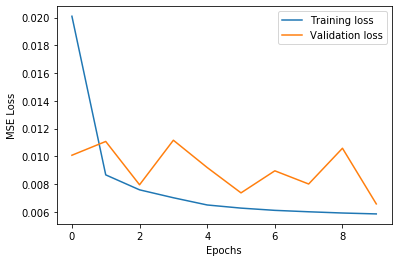

Loading data into RAM
Z500 - 0: 80.54242071757395
T850 - 0: 0.7353684401225488


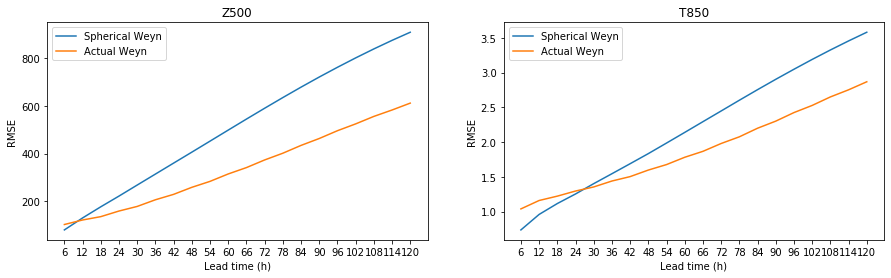

In [5]:
description = "all_const_no_orog"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 3, 4, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No lats

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 0.020  - val_loss: 0.01081  - time: 1805.752926
Epoch:   2/ 10  - loss: 0.008  - val_loss: 0.00917  - time: 1802.993863
Epoch:   3/ 10  - loss: 0.008  - val_loss: 0.00852  - time: 1802.927879
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.00759  - time: 1802.517749
Epoch:   5/ 10  - loss: 0.007  - val_loss: 0.00859  - time: 1798.941659
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00740  - time: 1795.554840
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00837  - time: 1797.589675
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00666  - time: 1804.061601
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.00862  - time: 1790.136331
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00695  - time: 1802.363060


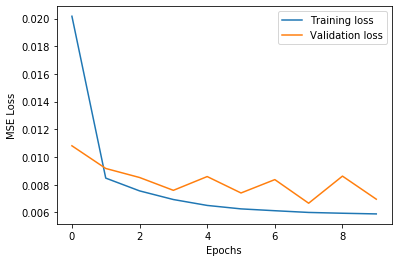

Loading data into RAM
Z500 - 0: 84.93214321476428
T850 - 0: 0.7416516136707456


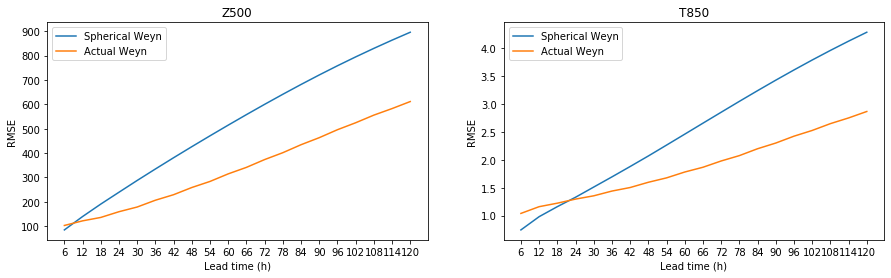

In [6]:
description = "all_const_no_lats"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 4, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No lsm

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 0.022  - val_loss: 0.01069  - time: 1817.650883
Epoch:   2/ 10  - loss: 0.009  - val_loss: 0.00829  - time: 1821.635124
Epoch:   3/ 10  - loss: 0.007  - val_loss: 0.01009  - time: 1821.643016
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.00716  - time: 1819.830657
Epoch:   5/ 10  - loss: 0.007  - val_loss: 0.00740  - time: 1815.523921
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00766  - time: 1812.692648
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00755  - time: 1813.984504
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00742  - time: 1813.822827
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.00680  - time: 1814.782489
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00693  - time: 1814.840466


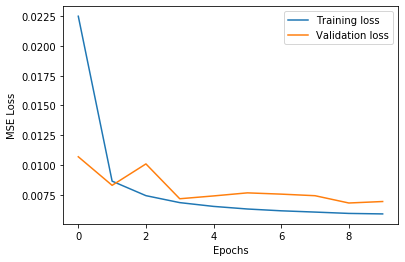

Loading data into RAM
Z500 - 0: 82.62949545555695
T850 - 0: 0.7449635845155385


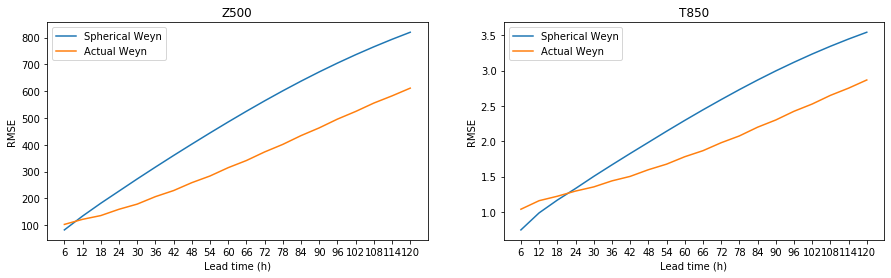

In [7]:
description = "all_const_no_lsm"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 5, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No rad

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 0.027  - val_loss: 0.01778  - time: 1774.564314
Epoch:   2/ 10  - loss: 0.009  - val_loss: 0.01007  - time: 1777.609523
Epoch:   3/ 10  - loss: 0.008  - val_loss: 0.01075  - time: 1777.421738
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.00775  - time: 1777.303389
Epoch:   5/ 10  - loss: 0.007  - val_loss: 0.00897  - time: 1772.744541
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00705  - time: 1772.014110
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00684  - time: 1774.492738
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00839  - time: 1789.808005
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.00746  - time: 1792.796295
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00689  - time: 1788.706683


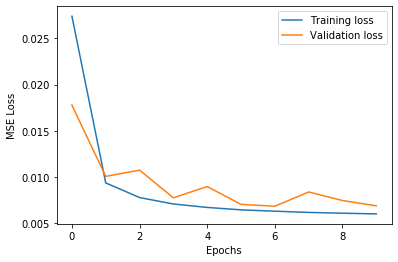

Loading data into RAM
Z500 - 0: 86.79639415765256
T850 - 0: 0.7387866938228609


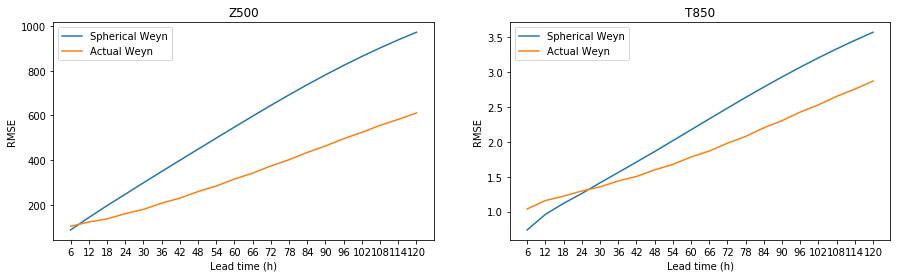

In [8]:
description = "all_const_no_rad"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 5]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, lsm, slt], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# No slt

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 0.024  - val_loss: 0.01210  - time: 1810.405781
Epoch:   2/ 10  - loss: 0.009  - val_loss: 0.00869  - time: 1801.582996
Epoch:   3/ 10  - loss: 0.008  - val_loss: 0.01011  - time: 1811.035497
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.00988  - time: 1844.737654
Epoch:   5/ 10  - loss: 0.006  - val_loss: 0.00889  - time: 1844.476659
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00711  - time: 1843.627941
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00899  - time: 1843.203835
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00666  - time: 1845.595662
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.00808  - time: 1843.134418
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00729  - time: 1844.966865


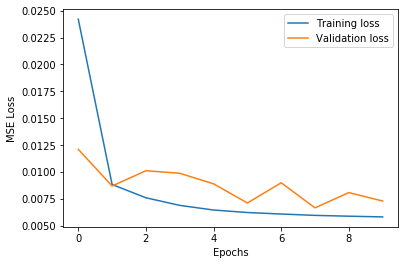

Loading data into RAM
Z500 - 0: 89.71451811189827
T850 - 0: 0.7435122510114122


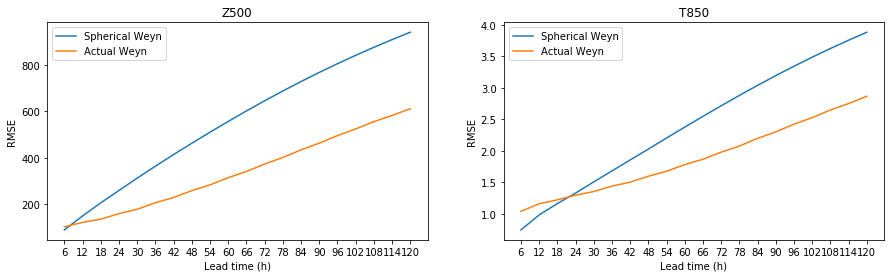

In [9]:
description = "all_const_no_slt"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 6]
in_features = len(feature_idx)
ds = xr.merge([z500, t850, orog, lats, lsm, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=nb_epochs, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# All constants + longitude

Loading data into RAM
Loading data into RAM
Epoch:   1/ 30  - loss: 0.022  - val_loss: 0.01251  - time: 2062.341349
Epoch:   2/ 30  - loss: 0.009  - val_loss: 0.01171  - time: 2258.024657
Epoch:   3/ 30  - loss: 0.008  - val_loss: 0.00782  - time: 2327.499802
Epoch:   4/ 30  - loss: 0.007  - val_loss: 0.00830  - time: 1920.829190
Epoch:   5/ 30  - loss: 0.006  - val_loss: 0.00796  - time: 1719.441113
Epoch:   6/ 30  - loss: 0.006  - val_loss: 0.00697  - time: 1721.425015
Epoch:   7/ 30  - loss: 0.006  - val_loss: 0.00668  - time: 1714.835390
Epoch:   8/ 30  - loss: 0.006  - val_loss: 0.00667  - time: 1717.912549
Epoch:   9/ 30  - loss: 0.006  - val_loss: 0.00926  - time: 1714.199634
Epoch:  10/ 30  - loss: 0.006  - val_loss: 0.00662  - time: 1709.325384
Epoch:  11/ 30  - loss: 0.006  - val_loss: 0.00666  - time: 1708.627176
Epoch:  12/ 30  - loss: 0.006  - val_loss: 0.00655  - time: 1705.364571
Epoch:  13/ 30  - loss: 0.006  - val_loss: 0.00869  - time: 1705.442092
Epoch:  14/ 30  - lo

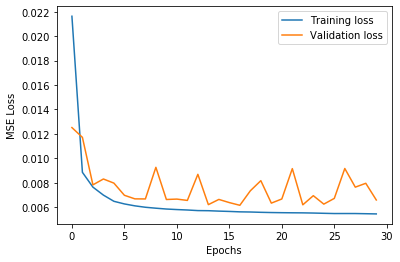

Loading data into RAM
Z500 - 0: 84.0413482964622
T850 - 0: 0.725652277632067


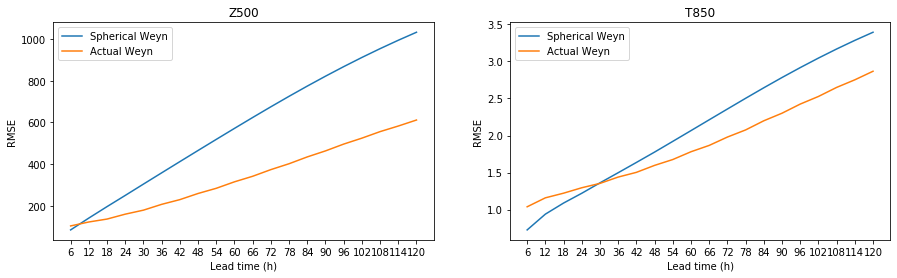

In [8]:
description = "all_const_lon"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# 'z500', 't850', 'orog', 'lat2d', 'lsm', 'slt', 'tisr', 'cos_lon', 'sin_lon'
in_features = 9
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad, cos_lon, sin_lon], compat='override')

train_mean_ = train_mean.copy()
train_std_ = train_std.copy()

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=30, lr=learning_rate, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean_, std=train_std_, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, preds, ds, ds_train, ds_valid, ds_test, rmse,
torch.cuda.empty_cache()

# Comparison

In [5]:
import matplotlib.pyplot as plt

metrics_path = '../data/healpix/metrics/'
rmse_noconst = xr.open_dataset(metrics_path + 'rmse_' + 'no_const' + '.nc')
rmse_all_const_no_orog = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_orog' + '.nc')
rmse_all_const_no_lats = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_lats' + '.nc')
rmse_all_const_no_lsm = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_lsm' + '.nc')
rmse_all_const_no_slt = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_slt' + '.nc')
rmse_all_const_no_rad = xr.open_dataset(metrics_path + 'rmse_' + 'all_const_no_rad' + '.nc')
rmse_all_const = xr.open_dataset(metrics_path + 'rmse_' + 'all_const' + '.nc')

lead_times = np.arange(6, max_lead_time + 6, 6)
xlabels = [str(t) if t%4 == 0 else '' for t in lead_times] if lead_times[0] < 12 else lead_times
labels = np.array(['No static\nfeatures', 'No orog', 'No lats', 'No land-\nsea', 'No rad', 'No soil\ntype', 
                   'All static\nfeatures'])
colors = np.array(['red', 'blue', 'limegreen', 'skyblue', 'yellow', 'orange', 'darkviolet'])

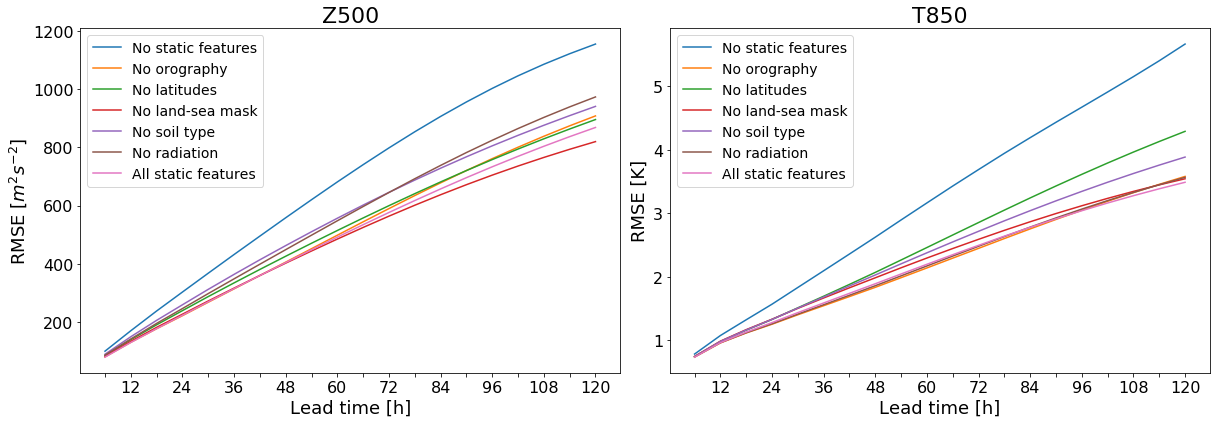

In [2]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

ax1.plot(lead_times, rmse_noconst.z.values, label='No static features')
ax1.plot(lead_times, rmse_all_const_no_orog.z.values, label='No orography')
ax1.plot(lead_times, rmse_all_const_no_lats.z.values, label='No latitudes')
ax1.plot(lead_times, rmse_all_const_no_lsm.z.values, label='No land-sea mask')
ax1.plot(lead_times, rmse_all_const_no_slt.z.values, label='No soil type')
ax1.plot(lead_times, rmse_all_const_no_rad.z.values, label='No radiation')
ax1.plot(lead_times, rmse_all_const.z.values, label='All static features')

ax2.plot(lead_times, rmse_noconst.t.values, label='No static features')
ax2.plot(lead_times, rmse_all_const_no_orog.t.values, label='No orography')
ax2.plot(lead_times, rmse_all_const_no_lats.t.values, label='No latitudes')
ax2.plot(lead_times, rmse_all_const_no_lsm.t.values, label='No land-sea mask')
ax2.plot(lead_times, rmse_all_const_no_slt.t.values, label='No soil type')
ax2.plot(lead_times, rmse_all_const_no_rad.t.values, label='No radiation')
ax2.plot(lead_times, rmse_all_const.t.values, label='All static features')


ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax1.set_xlabel('Lead time [h]', fontsize='18')
ax2.set_xlabel('Lead time [h]', fontsize='18')
ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

plt.tight_layout()

#plt.savefig('static_rmse_curves.eps', format='eps', bbox_inches='tight')

plt.show()

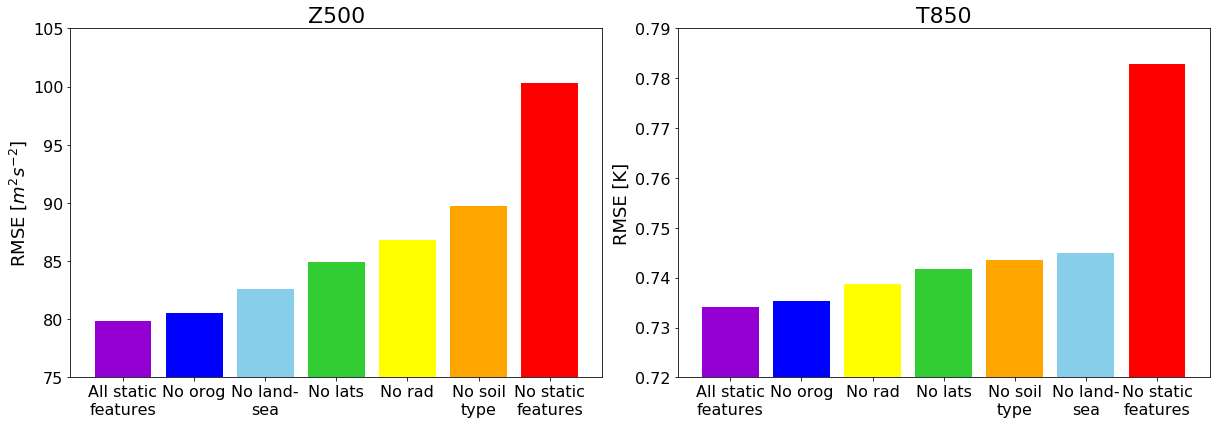

In [12]:
rmse_noconst0 = rmse_noconst.isel(lead_time=0)
rmse_all_const_no_orog0 = rmse_all_const_no_orog.isel(lead_time=0)
rmse_all_const_no_lats0 = rmse_all_const_no_lats.isel(lead_time=0)
rmse_all_const_no_lsm0 = rmse_all_const_no_lsm.isel(lead_time=0)
rmse_all_const_no_slt0 = rmse_all_const_no_slt.isel(lead_time=0)
rmse_all_const_no_rad0 = rmse_all_const_no_rad.isel(lead_time=0)
rmse_all_const0 = rmse_all_const.isel(lead_time=0)

rmses_0 = [rmse_noconst0, rmse_all_const_no_orog0, rmse_all_const_no_lats0, rmse_all_const_no_lsm0, 
           rmse_all_const_no_rad0, rmse_all_const_no_slt0, rmse_all_const0]
rmses_z_0 = np.array([r.z.values for r in rmses_0])
rmses_t_0 = np.array([r.t.values for r in rmses_0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

f.suptitle('RMSE of first prediction, sorted in ascending order', fontsize=22, y=1.1)

N = len(labels)

ax1.bar(np.arange(N), rmses_z_0[np.argsort(rmses_z_0).tolist()], color=colors[np.argsort(rmses_z_0).tolist()])
ax1.set_xticks(np.arange(N))
ax1.set_ylim([75, 105])
ax1.set_xticklabels(labels[np.argsort(rmses_z_0).tolist()], fontsize=16)

ax2.bar(np.arange(N), rmses_t_0[np.argsort(rmses_t_0).tolist()], color=colors[np.argsort(rmses_t_0).tolist()])
ax2.set_xticks(np.arange(N))
ax2.set_ylim([0.72, 0.79])
ax2.set_xticklabels(labels[np.argsort(rmses_t_0).tolist()], fontsize=16)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')

plt.tight_layout()

#plt.savefig('static_rmse_first.eps', format='eps', bbox_inches='tight')

plt.show()

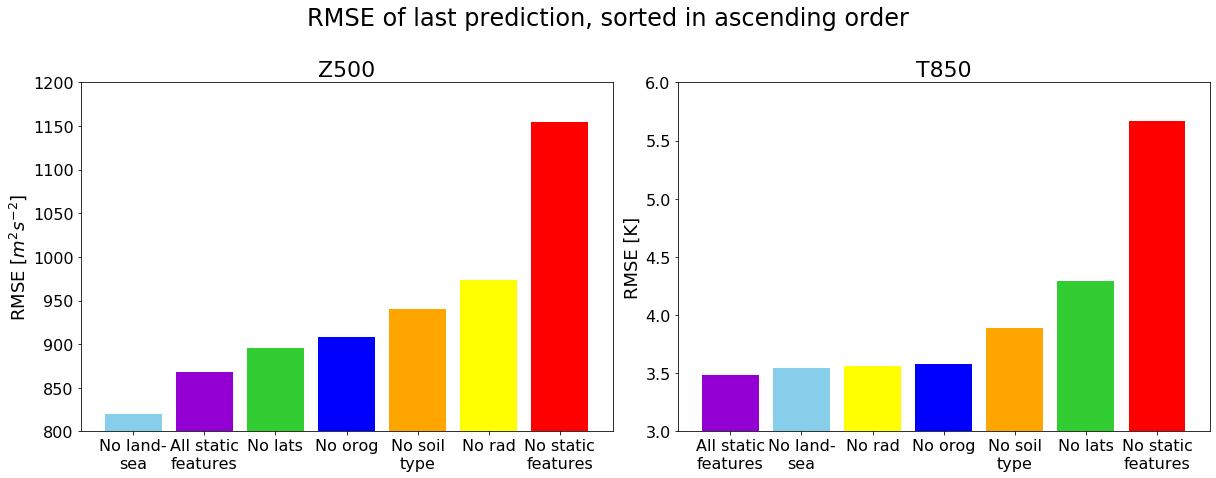

In [10]:
rmse_noconst_last = rmse_noconst.isel(lead_time=-1)
rmse_all_const_no_orog_last = rmse_all_const_no_orog.isel(lead_time=-1)
rmse_all_const_no_lats_last = rmse_all_const_no_lats.isel(lead_time=-1)
rmse_all_const_no_lsm_last = rmse_all_const_no_lsm.isel(lead_time=-1)
rmse_all_const_no_slt_last = rmse_all_const_no_slt.isel(lead_time=-1)
rmse_all_const_no_rad_last = rmse_all_const_no_rad.isel(lead_time=-1)
rmse_all_const_last = rmse_all_const.isel(lead_time=-1)

rmses_last = [rmse_noconst_last, rmse_all_const_no_orog_last, rmse_all_const_no_lats_last, 
              rmse_all_const_no_lsm_last, rmse_all_const_no_rad_last, rmse_all_const_no_slt_last, 
              rmse_all_const_last]
rmses_z_last = np.array([r.z.values for r in rmses_last])
rmses_t_last = np.array([r.t.values for r in rmses_last])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

f.suptitle('RMSE of last prediction, sorted in ascending order', fontsize=24, y=1.1)

N = len(labels)

ax1.bar(np.arange(N), rmses_z_last[np.argsort(rmses_z_last).tolist()], 
        color=colors[np.argsort(rmses_z_last).tolist()])
ax1.set_xticks(np.arange(N))
ax1.set_ylim([800, 1200])
ax1.set_xticklabels(labels[np.argsort(rmses_z_last).tolist()], fontsize='16')

ax2.bar(np.arange(N), rmses_t_last[np.argsort(rmses_t_last).tolist()], 
        color=colors[np.argsort(rmses_t_last).tolist()])
ax2.set_xticks(np.arange(N))
ax2.set_ylim([3, 6])
ax2.set_xticklabels(labels[np.argsort(rmses_t_last).tolist()], fontsize='16')

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
ax2.set_ylabel('RMSE [K]', fontsize='18')
ax1.set_title('Z500', fontsize='22')
ax2.set_title('T850', fontsize='22')

plt.tight_layout()

#plt.savefig('static_rmse_last.eps', format='eps', bbox_inches='tight')

plt.show()